In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

Get the value of ah from luminosity scaling, using methodology as in Krause et al. 2015

In [3]:
# Set up a function for the comoving distance

def com(z_, OmC, OmB, HH0, Nnu):
    """ Gets the comoving distance in units of Mpc/h at a given redshift, z_ (assuming the cosmology defined in the params file). """
    
    OmR	=	2.47*10**(-5)/(HH0/100.)**2
    OmN	=	Nnu*(7./8.)*(4./11.)**(4./3.)*OmR
    OmL = 1. - OmC - OmB - OmR - OmN
    c=2.99792458*10**(8)
    H0	=	10**(5)/c
    
    def chi_int(z):
        return 1. / (H0 * ( (OmC+OmB)*(1+z)**3 + OmL + (OmR+OmN) * (1+z)**4 )**(0.5))

    if hasattr(z_, "__len__"):
        chi=np.zeros((len(z_)))
        for zi in range(0,len(z_)):
            #print "zi in com=", zi
            chi[zi] = scipy.integrate.quad(chi_int,0,z_[zi])[0]
    else:
        chi = scipy.integrate.quad(chi_int, 0, z_)[0]

    return chi



In [4]:
# Set up the Schechter luminosity function parameters from Krause et al. 2015

z_1 = 0.28; z_2 = 0.77; 
mlim_1 = 22.; mlim_2 = 27.; 
Mp = -22.
Lp = 10.**(-0.4*(Mp-Mp))

# Power law parameters
alpha_h = 0.081; beta_h = 2.1
A_0 = 4.9; beta = 1.30;

# We are using parameters from Krause et al. 2015, red galaxies
Mr_s = -20.34; Q = 1.8; alpha = -0.57; phi_0 = 1.1 * 10**(-2); P = -1.2


In [5]:
# Compute phi*(z) and M*(z) / L*(z), where z is the lens redshift 
zL1 = np.linspace(0.16, 0.36, 200); zL2 = np.linspace(0.025, 1.175, 200)

phi_s_1 = phi_0 * 10**(0.4 * P*zL1); 
phi_s_2 = phi_0 * 10**(0.4 * P*zL2); 

Ms_1 = Mr_s - Q * ( zL1 - 0.1 ); Ms_2 = Mr_s - Q * ( zL2 - 0.1)
Ls_1 = 10.**(-0.4 *(Ms_1-Mp)); Ls_2 = 10.**(-0.4 *(Ms_2-Mp))

In [6]:
# Import the k correction and EC correction from Poggianti (assuming elliptical galaxies)
(z_k, kcorr, x,x,x) = np.loadtxt('../txtfiles/kcorr.dat', unpack=True)
(z_e, ecorr, x,x,x) = np.loadtxt('../txtfiles/ecorr.dat', unpack=True)

kcorr_interp = scipy.interpolate.interp1d(z_k, kcorr)
ecorr_interp = scipy.interpolate.interp1d(z_e, ecorr)

kcorr_1 = kcorr_interp(zL1)
ecorr_1 = ecorr_interp(zL1)
kcorr_2 = kcorr_interp(zL2)
ecorr_2 = ecorr_interp(zL2)

In [7]:
# Get the absolute magnitude that corresponds to the limiting apparent magnitude
dl_1 = com(zL1, 0.2, 0.05, 70., 3.046) * (1. + zL1)
dl_2 = com(zL2, 0.2, 0.05, 70., 3.046) * (1. + zL2)

Mlim_1 = mlim_1 - (5. * np.log10(dl_1) + 25. + kcorr_1 + ecorr_1); Llim_1 = 10.**(-0.4 * (Mlim_1-Mp))
#print "Mlim 1=", Mlim_1
Mlim_2 = mlim_2 - (5. * np.log10(dl_2) + 25. + kcorr_2 + ecorr_2); Llim_2 = 10.**(-0.4 * (Mlim_2-Mp))
#print "Mlim 2=", Mlim_2


In [8]:
# Get the luminosity vectors over which to integrate
# For each case, there will be a list of these, one for each redshift,
# because the limiting values if z-dependent

L_1 = [0] * len(zL1)
for zi in range(0,len(zL1)):
    L_1[zi] = scipy.logspace(np.log10(Llim_1[zi]), 2, 1000)
L_2 = [0]*len(zL2)
for zi in range(0,len(zL2)):
    L_2[zi] = scipy.logspace(np.log10(Llim_2[zi]), 2, 1000)

# Now get phi(L,z), where this exists for each z because the lenghts of the L vectors are different.
phi_func_1 = [0]*len(zL1)
for zi in range(0,len(zL1)):
    phi_func_1[zi]= np.zeros((len(L_1[zi]),len(zL1) ))
    for li in range(0,len(L_1[zi])):
        phi_func_1[zi][li, zi] = phi_s_1[zi] * (L_1[zi][li] / Ls_1[zi]) ** (alpha) * np.exp(- L_1[zi][li] / Ls_1[zi])

phi_func_2 = [0]*len(zL2)
for zi in range(0,len(zL2)):
    phi_func_2[zi]= np.zeros((len(L_2[zi]),len(zL2) ))
    for li in range(0,len(L_2[zi])):
        phi_func_2[zi][li, zi] = phi_s_2[zi] * (L_2[zi][li] / Ls_2[zi]) ** (alpha) * np.exp(- L_2[zi][li] / Ls_2[zi])        
       

In [9]:
# Get the numerator and denom (norm) of the required averages in luminosity, still as functions of zL

norm_1 = np.zeros(len(zL1)); num_ah_1 = np.zeros(len(zL1)); num_Ai_1 = np.zeros(len(zL1)) 
avgL_1 = np.zeros(len(zL1))
for zi in range(len(zL1)):
    norm_1[zi] = scipy.integrate.simps(phi_func_1[zi][:, zi], L_1[zi])
    num_ah_1[zi] = scipy.integrate.simps(phi_func_1[zi][:, zi] * (alpha_h * (L_1[zi]) / Lp)**(beta_h), L_1[zi])
    num_Ai_1[zi] = scipy.integrate.simps(phi_func_1[zi][:, zi] * (A_0 * (L_1[zi]) / Lp)**(beta), L_1[zi])
    avgL_1[zi] = scipy.integrate.simps(phi_func_1[zi][:, zi] * L_1[zi] / Lp, L_1[zi])
    
norm_2 = np.zeros(len(zL2)); num_ah_2 = np.zeros(len(zL2)); num_Ai_2 = np.zeros(len(zL2))
avgL_2=np.zeros(len(zL2))
for zi in range(len(zL2)):
    norm_2[zi] = scipy.integrate.simps(phi_func_2[zi][:, zi], L_2[zi])
    num_ah_2[zi] = scipy.integrate.simps(phi_func_2[zi][:, zi] * (alpha_h * (L_2[zi]) / Lp)**(beta_h), L_2[zi])
    num_Ai_2[zi] = scipy.integrate.simps(phi_func_2[zi][:, zi] * (A_0 * (L_2[zi]) / Lp)**(beta), L_2[zi])
    avgL_2[zi] = scipy.integrate.simps(phi_func_2[zi][:, zi] * L_2[zi] / Lp, L_2[zi])


ValueError: x and y can be no greater than 2-D

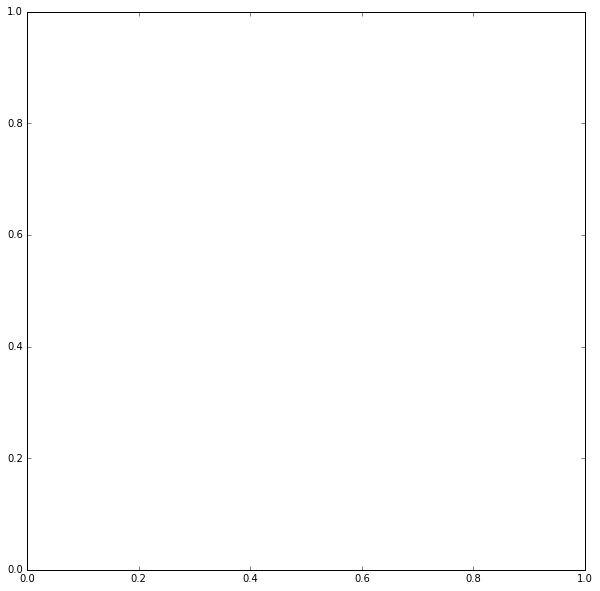

In [10]:
#print "phi_func_1 / norm_1 =", phi_func_1 / norm_1 

plt.figure(figsize=(10,10))
plt.plot(L_1, phi_func_1 / norm_1 , 'm', label='SDSS')
plt.hold(True)
plt.plot(L_2, phi_func_2 / norm_2 , 'g', label='LSST+DESI')
plt.hold(True)
plt.axvline(x=Ls_1,color='m', linestyle = '--')
plt.hold(True)
plt.axvline(x=Ls_2,color='g', linestyle = '--')
plt.xlabel('L/Lp', fontsize=20)
plt.ylabel('$\phi$', fontsize=20)
plt.xlim(0., 1.5)
#plt.ylim(10**(-8),1000)
plt.tick_params(axis='both', labelsize='18')
plt.legend()
plt.title('Luminosity function, normalized', fontsize=20)
#plt.savefig('../plots/Luminosity_functions.pdf')
#plt.legend()
plt.show()

In [11]:
L0 = 10.**(-0.4 * (-22.))
print "L0=", L0

#a_h = [0]*(len(z))
#for i in range(0, len(z)):
#num = scipy.integrate.simps(phi_func[i, :] * alpha_h * (L_list[i] / L0)**beta_h, L_list[i])
a_h_1 = scipy.integrate.simps(phi_func_1 / norm_1 * alpha_h * (L_1 / L0)**beta_h * L_1, np.log(L_1))
a_h_2 = scipy.integrate.simps(phi_func_2 / norm_2 * alpha_h * (L_2 / L0)**beta_h * L_2, np.log(L_2))

plt.figure(figsize=(10,10))
plt.semilogx(L_1, phi_func_1 / norm_1* alpha_h * (L_1 / L0)**beta_h, 'm', label='SDSS')
plt.hold(True)
plt.semilogx(L_2, phi_func_2 / norm_2* alpha_h * (L_2 / L0)**beta_h, 'g', label='LSST+DESI')
plt.xlabel("Luminosity (arbitrary units)", fontsize=20)
plt.ylabel("$a_h(L) \phi(L)$", fontsize=20)
plt.tick_params(axis='both', labelsize='18')
plt.savefig('../plots/Lum_func_times_ah.pdf')
plt.legend()
plt.show()

print "ah 1=", a_h_1, "ah 2=", a_h_2

L0= 630957344.48


TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
# Get the normalized redshift distribution in terms of spec z
#dNdz = get_NofZ([1.24, 0.51, 1.01], 'Smail', z)
#dNdz = get_NofZ([2.338, 0.303], 'Nakajima', z)

# and integrate over it

#a_h_intz = scipy.integrate.simps(a_h*dNdz, z)
print "A=", a_h